In [445]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## 0. Loading the data

In [446]:
#load data/moviesummaries/character.metadata.tsv
character_metadata = pd.read_csv('../data/moviesummaries/character.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/plot_summaries.txt
plot_summaries = pd.read_csv('../data/moviesummaries/plot_summaries.txt', sep='\t', header=None)

#load data/moviesummaries/movie.metadata.tsv
movie_metadata = pd.read_csv('../data/moviesummaries/movie.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/name.clusters.txt
name_clusters = pd.read_csv('../data/moviesummaries/name.clusters.txt', sep='\t', header=None)


In [447]:
# Rename columns of each dataset to match documentation
character_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", 
                              "Actor height", "Actor ethnicity", "Actor name", "Actor age", "Freebase character/actor map ID", 
                              "Freebase character ID", "Freebase actor ID"]

plot_summaries.columns = ["Wikipedia movie ID", "Summary"]

movie_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie revenue", "Movie runtime",
                          "Movie languages", "Movie countries", "Movie genres"]

name_clusters.columns = ["Character name", "Freebase character/actor map ID"]

We get 4 different dataframes; we'll merge movie_metadata and plot_summaries together since it makes sense to get the plot information directly linked with the movie metadata, and keep the others as is.

## 1. Preprocessing plot and metadata about movies

We can see from the columns name that we can simply add the plot summaries of the movies to the movie metadata dataframe. Let's first take a look at how many data we have in each dataset :

In [448]:
# Print the size of each dataset
print("Number of data in the metadata dataframe :", movie_metadata.shape[0])
print("Number of data in the plot summaries dataframe :", plot_summaries.shape[0])

Number of data in the metadata dataframe : 81741
Number of data in the plot summaries dataframe : 42303


We can see that approximately half of the movies in the metadata have a plot description. Let's now join the two dataset on the ID column :

In [449]:
# Merge the movie_metadata and plot_summaries dataframes on the Wikipedia movie ID, without dropping the rows whitout summary, but dropping
# the plot without a matching movie
all_movies = movie_metadata.merge(plot_summaries, on="Wikipedia movie ID", how="left")
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [450]:
# Check the number and percentage of null values in each column of plot_summaries as well as the number of different values in each column.
all_movies_null = pd.DataFrame(all_movies.isnull().sum(), columns=['Number of null values'])
all_movies_null['Percentage of null values'] = all_movies_null['Number of null values'] / len(all_movies)
all_movies_null['Number of unique values'] = all_movies.nunique()

all_movies_null

,Number of null values,Percentage of null values,Number of unique values
Wikipedia movie ID,0,0.000000,81741
Freebase movie ID,0,0.000000,81741
Movie name,0,0.000000,75478
Movie release date,6902,0.084437,20389
Movie revenue,73340,0.897224,7362
Movie runtime,20450,0.250180,597
Movie languages,0,0.000000,1817
Movie countries,0,0.000000,2124
Movie genres,0,0.000000,23817
Summary,39537,0.483686,42196


As mentioned above, we see that approximately 48% percent of the movie dataset doesn't have a corresponding plot summary!

But what about dupplicated plot summaries? Let's check that :

In [451]:
# Show plot summary duplicates which are not NaNs
duplicate_plot_movies = all_movies[all_movies.duplicated(subset=['Summary'], keep = False) & all_movies['Summary'].notnull()]

# Print number of plot summaries having at least one duplicate
print("Number of plot summaries having at least one duplicate :", duplicate_plot_movies['Summary'].nunique())

duplicate_plot_movies[['Wikipedia movie ID', 'Movie name', 'Summary']].sort_values(by=['Summary'])


Number of plot summaries having at least one duplicate : 5


,Wikipedia movie ID,Movie name,Summary
4551,14055212,The Trial of Madame X,A woman is thrown out of her home by her jealo...
18993,14022275,Madame X,A woman is thrown out of her home by her jealo...
49381,14037732,Madame X,A woman is thrown out of her home by her jealo...
57569,14051944,Madame X,A woman is thrown out of her home by her jealo...
65014,14053389,Madame X,A woman is thrown out of her home by her jealo...
28621,29481480,Drohi,An orphan Raghav turns into a ruthless contrac...
67464,25493367,Antham,An orphan Raghav turns into a ruthless contrac...
15783,14616220,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
57508,28852030,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
22185,19609453,Amar Deep,Raja was adopted by a criminal don at a very ...


We see that there are 5 different plot summaries that have at least one duplicate. 

In some cases, the duplicate has the same movie name but in other cases, the duplicate has a different movie name. 

Therefore, we can't choose which duplicate is the "correct" one.

We therefore choose here either to discard all duplicates or to keep them all.

# ICI PEUT ETRE LES ENLEVER? 
duplicate de ligne, mais pas les autres

Let's now take a look at the movies release dates. By looking at the data, we see 4 cases :
 - The release date is a year 
 - The release date is a month and a year 
 - The release date is a day, a month and a year 
 - The release date is not a number

Let's convert every entry to only a year when it's possible :


Defining three functions checking which format is valid for a specific string

In [452]:
# import the datetime module
import datetime

 # Function to check if a string matches the specified date format
 
 # For format 1 : YYYY-MM-DD
def valid_format1(date_string, date_format='%Y-%m-%d'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False

# For format 2 : YYYY-MM
def valid_format2(date_string, date_format='%Y-%m'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False   

# For format 3 : YYYY
def valid_format3(date_string, date_format='%Y'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False
        

Creating a function to keep only the year, if the data is in one of the three formats defined above

In [453]:
import datetime
import pandas as pd
import numpy as np

def keep_the_year(date_full, key):
    
    # Converting tyhe date full column to a dataframe, and replacing the nan with null values
    date_full = pd.DataFrame(date_full)
    date_full  = date_full.fillna(" ")
    
    # creating a dataframe with the same size as date_full, but with nan values
    date_formated = pd.DataFrame(np.nan, index=date_full.index, columns=date_full.columns) 

    # Define date formats
    format1 = '%Y-%m-%d'
    format2 = '%Y-%m'
    format3 = '%Y'

    # Iterate through the values in the datefull column, checking which format it matches, and converting it to datetime format
    for (index,i) in enumerate(date_full[key]):
        if valid_format1(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format1).date()
        elif valid_format2(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format2).date()
        elif valid_format3(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format3).date()
        
    #  Keeping only the year 
    date_year = pd.DatetimeIndex(date_formated[key]).year
    #Converting to int
    date_year = date_year.astype('Int64')
    return date_year

Converting the movie release date to keep only the year for the all_movie table :

In [454]:
# Setting out of bound values to nan
all_movies['Movie release date'][62836] = np.nan
# Calling the function
all_movies['Movie release date'] = keep_the_year(all_movies['Movie release date'], key='Movie release date')

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_37399/2584046882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies['Movie release date'][62836] = np.nan


In [455]:
all_movies.head(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",NaN
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",NaN
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",NaN


Now, we have a proper dataframe containing metadata and plot summaries about movies.

## 2. Preprocessing characters metadata

In [456]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
396027,3168732,/m/08wry6,1998-04-18,Tori,1964-12-04,F,1.64,/m/0xnvg,Marisa Tomei,33.0,/m/0cg0799,/m/0gy97ys,/m/01g257
388654,1127016,/m/048l67,2003-02-28,NaN,1918-05-18,M,NaN,NaN,Massimo Girotti,84.0,/m/02vcddl,NaN,/m/0287kv8
97701,348979,/m/01z0n6,1988-11-18,NaN,1975-10-20,F,1.65,NaN,Natalie Gregory,13.0,/m/02vbvtr,NaN,/m/06psd5
168675,3581722,/m/09mytf,2004-09-30,Luk,1945-08-12,M,NaN,NaN,Kevin Schon,59.0,/m/0h7g1r9,/m/0h7g17s,/m/03cdzsc
444520,24077357,/m/07khzdj,1993-04-09,NaN,1961-09-30,M,1.83,NaN,Eric Stoltz,31.0,/m/0cg1sbt,NaN,/m/033tln
384469,24929092,/m/09gnxbl,2009,NaN,NaN,NaN,NaN,NaN,Marcelo Armand,NaN,/m/0gbqh3h,NaN,/m/0gbqh3f
333608,27375211,/m/05sqdjb,2010-05-14,Oona,1973-04-08,F,1.65,NaN,Emma Caulfield,37.0,/m/05yvj5c,/m/05yvj5g,/m/01f9pf
218018,779790,/m/03br82,1991-12-28,NaN,1933-11-07,M,NaN,NaN,Ernesto Gómez Cruz,58.0,/m/0cw0d4c,NaN,/m/0cyffg
143224,18724476,/m/04gqgw3,2005-11,NaN,1943-06-24,M,1.93,/m/0x67,Georg Stanford Brown,NaN,/m/0cg2txt,NaN,/m/06j2vh
272944,4518130,/m/0c6rs8,1971-05-26,NaN,1908-08-25,M,NaN,NaN,Walter Burke,62.0,/m/0cgnc4n,NaN,/m/0bwcgt


Taking a quick look, we see that we encounter the same problem with the "Movie release date" and the "Actor date of birth" columns as seen before. Let's convert every entry to only a year when it's possible :

In [457]:
# Setting out of bound value to nan
character_metadata['Movie release date'][67624:67639] = np.nan
# Calling the function
character_metadata['Movie release date'] = keep_the_year(character_metadata['Movie release date'], key='Movie release date')

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_37399/1576258549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  character_metadata['Movie release date'][67624:67639] = np.nan


## For the actor date of birth, too many out of bounds values, is it really usefull to convert it since we already have their age ?

In [458]:
#character_metadata['Actor date of birth'][11550] = np.nan
#character_metadata['Actor date of birth'][39427] = np.nan
#character_metadata['Actor date of birth'][42283] = np.nan
#character_metadata['Actor date of birth'][45080] = np.nan
#character_metadata['Actor date of birth'][80339] = np.nan
#character_metadata['Actor date of birth'] = keep_the_year(character_metadata['Actor date of birth'], key='Actor date of birth')

In [459]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
43663,10706032,/m/02qmshf,1964,Mrs. Laxmi Hukumat Rai,NaN,F,NaN,NaN,Sulochana Chatterjee,NaN,/m/0h6nkd8,/m/0h6nkdb,/m/0gdk17g
161173,21662131,/m/05mzt3t,1975,Billy,1949-08-31,M,1.80,/m/033tf_,Richard Gere,25.0,/m/0gy8wx_,/m/0gy8wy1,/m/01438g
248465,15467438,/m/03mb97f,1994,NaN,1952-06,F,NaN,NaN,Janine Duvitski,NaN,/m/040ns_j,NaN,/m/09jv74
228516,8417343,/m/0272p1c,2001,NaN,1972-09-06,M,1.79,NaN,Dylan Bruno,28.0,/m/03lwhnj,NaN,/m/0b2p4m
228051,4278211,/m/0btsjp,1970,NaN,1905-08-09,M,NaN,NaN,Leo Genn,64.0,/m/0cgn53j,NaN,/m/04xbs6
14000,1544670,/m/0595bk,1954,NaN,1928-03-10,F,NaN,NaN,Sara Montiel,26.0,/m/03l5r85,NaN,/m/01rfjyg
383715,27348158,/m/0by1wcr,1943,NaN,1912-04-29,M,1.80,NaN,Richard Carlson,31.0,/m/0bylc2y,NaN,/m/071bby
183124,24704005,/m/080kdj2,1990,Eric,1971-06-04,M,1.85,/m/041rx,Noah Wyle,18.0,/m/0gy9mth,/m/0gy9mtk,/m/01t6xz
358662,7019138,/m/0h0lyq,1928,Valet,1893-03-27,M,NaN,NaN,Otto Matieson,NaN,/m/0l9ff9w,/m/0l9ff9z,/m/03y91xm
417797,24569271,/m/080d9x1,1990,NaN,1960-07-26,M,NaN,NaN,Chinni Jayanth,29.0,/m/09j2vfx,NaN,/m/04ydm1p


## Learning more about the data

Let's take a look at the evolution of the film production through the years

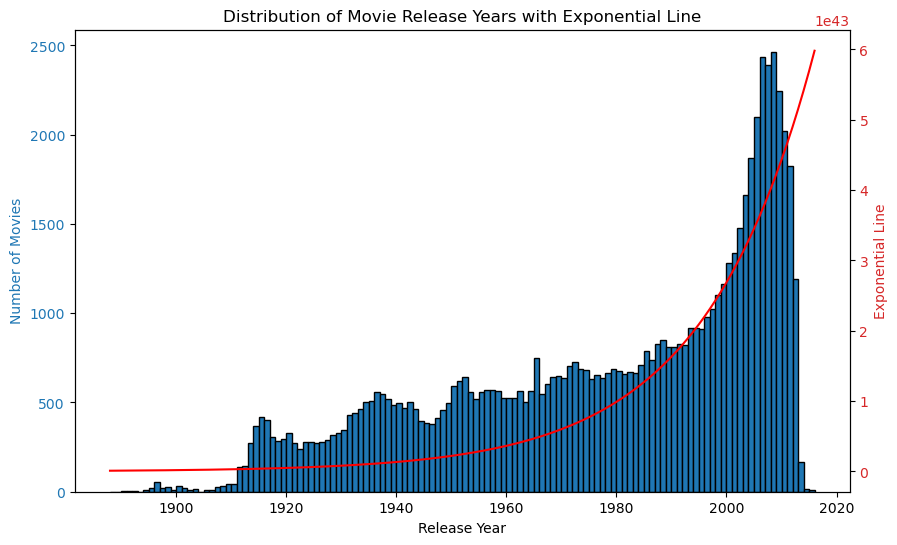

In [460]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating an histogram plotting the values of 'year'
ax1.hist(all_movies['Movie release date'].dropna(), bins=range(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1), edgecolor='black', label='Movie Releases')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Adding an exponential line
ax2 = ax1.twinx()
x_values = np.arange(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1, 1)
y_values = np.exp(0.05 * x_values)  # You can adjust the exponent and other parameters
ax2.plot(x_values, y_values, label='Exponential Line', color='red')
ax2.set_ylabel('Exponential Line', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Movie Release Years with Exponential Line')
plt.show()

-> We have way more data for recent films

# À faire

 - Merge movie metadata et character metadata??? à demander
 - Changer date avec code de clara -> Clara 
 - Filtrer les datas: enlever colonnes inutiles??? à demander
 - Comprendre les dictionary structure -> Faye


 - Plot nb films/années -> dire qu'on aura plus de données pour récemment -> Clara
 - Bar plot pays -> notre étude sera plus représentative des US -> Clara
 - Bar plot genre ???


Partie de romain:
 - sortir % NaN des revenue -> Faye